In [ ]:
import os
import cv2
import selectivesearch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
#import torch 
# from torch.utils.data import Dataset

In [3]:
# Define the paths to the image folder and annotations
images_path = "../Potholes/test_imgs"
annotations_path = "../Potholes/test_imgs"
# images_path = "../Potholes/annotated-images"
# annotations_path = "../Potholes/annotated-images"

TARGET_WIDTH, TARGET_HEIGHT = 400, 400

# %%
# Helper function to parse the XML file for ground truth bounding boxes
def parse_xml(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))

    return boxes

In [4]:
# Helper function to display an image with bounding boxes
def visualize_image(image_filename, image, boxes, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    adjusted_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in boxes]
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in adjusted_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals:
        for (x, y, w, h) in proposals:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv2.putText(image, image_filename, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
# Function to run Selective Search and obtain proposals
def get_proposals(image, num_proposals):
    _, regions = selectivesearch.selective_search(image, scale=10, sigma=0.8, min_size=100)
    proposals = []
    for r in regions:
        if r['rect'] in proposals:
            continue
        x, y, w, h = r['rect']
        if w > 20 and h > 20:  # Filter small regions
            proposals.append((x, y, w, h))
    return proposals[:num_proposals]

c:\Users\alba\.conda\envs\DL\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


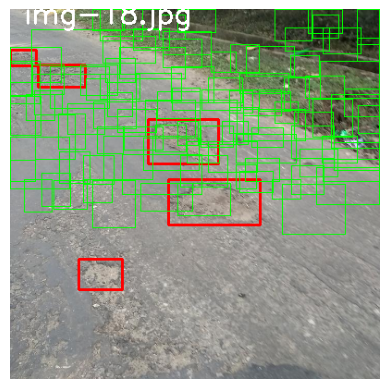

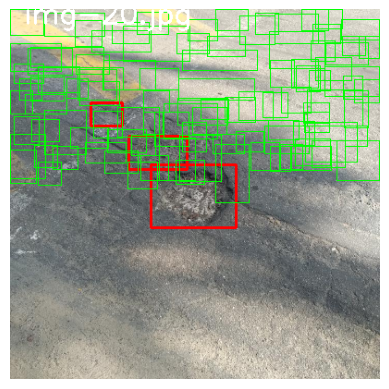

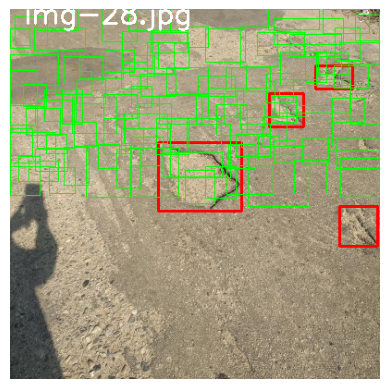

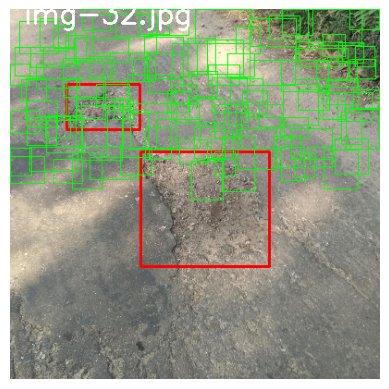

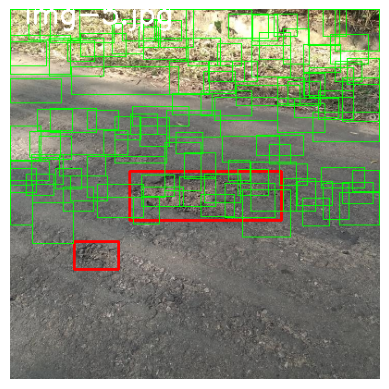

In [5]:
# Loop through images, resize if needed, and apply Selective Search
# image_counter = 0
for image_filename in os.listdir(images_path):
    if image_filename.lower().endswith(".jpg"):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.lower().replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)

        image = cv2.imread(image_path)
        
        # Calculate scaling factors
        orig_height, orig_width = image.shape[:2]
        scale_x = TARGET_WIDTH / orig_width
        scale_y = TARGET_HEIGHT / orig_height

        # Resize the image to improve Selective Search efficiency
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

        # # Run Selective Search on resized image
        # proposals = get_proposals(resized_image, num_proposals=100)

        # Convierte a tipo entero antes de pasar la imagen
        resized_image_int = (resized_image * 255).astype(np.uint8)  # si resized_image es tipo float en rango [0, 1]
        # o simplemente
        #resized_image_int = resized_image.astype(np.uint8)  # si resized_image está en un rango válido de 0-255 pero en float

        # Usa esta versión convertida en las operaciones
        proposals = get_proposals(resized_image_int, num_proposals=100)

        if os.path.exists(xml_path):
            boxes = parse_xml(xml_path)
            visualize_image(image_filename, resized_image, boxes, proposals, scale_x=scale_x, scale_y=scale_y)  # To Display uncomment

        # Break to only visualize a few images
        # image_counter += 1
        # if image_counter >= 2:
        #     break

## METRICS: RECALL AND MABO

### Evaluate Proposals by Calculating Recall and ABO 
As we only have one class maybe ABO is enough


In [ ]:
# Constants
IOU_THRESHOLD = 0.5  # For recall calculation
TARGET_PROPOSALS = range(10, 200, 10)  # Range of number of proposals to test (adjust as needed)

# Function to calculate the IoU between to proposals(two boxes)
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxA_Area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_Area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxA_Area + boxB_Area - interArea)
    return iou

# Function to evaluate proposals on a single image using recall
def calc_recall(proposals, ground_truth_boxes, iou_threshold):
    recalled_boxes = 0
    for gt_box in ground_truth_boxes:
        max_iou = 0  # Variable to store the maximum IoU for this ground truth box
        for (x, y, w, h) in proposals:
            iou = calculate_iou(gt_box, (x, y, x + w, y + h))
            if iou > max_iou:
                max_iou = iou  # Update if a higher IoU is found
        # Only count if the maximum IoU exceeds the threshold
        if max_iou >= iou_threshold:
            recalled_boxes += 1
    recall = recalled_boxes / len(ground_truth_boxes)
    return recall

# Function to evaluate proposals on a single image using ABO
def calc_abo(proposals, ground_truth_boxes):
    sum_max_ious = 0
    for gt_box in ground_truth_boxes:
        max_iou = 0
        for (x, y, w, h) in proposals:
            iou = calculate_iou(gt_box, (x, y, x + w, y + h))
            max_iou= max(max_iou, iou)

        sum_max_ious += max_iou
    
    abo = sum_max_ious / len(ground_truth_boxes) 
    return abo
    

The following code is in case we want to test different thresholds

In [ ]:
# Evaluate over different thresholds
iou_thresholds=[0.5, 0.6, 0.7]
recalls={t: [] for t in iou_thresholds}

# Loop over images to evaluate proposals

for image_filename in os.listdir(images_path):
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)

        # Load image and ground truth
        image = cv2.imread(image_path)
        if os.path.exists(xml_path):
            ground_truth_boxes = parse_xml(xml_path)

            # Dimensions for resizing
            orig_height, orig_width = image.shape[:2]
            scale_x = TARGET_WIDTH / orig_width
            scale_y = TARGET_HEIGHT / orig_height

            # Resize ground truth boxes
            resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
            # Resize image and generate proposals
            resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            proposals = get_proposals(resized_image, num_proposals= 50)

            # Evaluate for each IoU threshold
            for t in iou_thresholds:
                recall = calc_recall(proposals, resized_gt_boxes, t)
                recalls[t].append(recall)

### Loop for evaluating the Recall and choosing the number of proposals



We now evaluate the best number of proposals, the next text includes a loop for evaluating the recall over different number of scales in different images and computing the average. 

img-18.jpg


c:\Users\jlgonzalo\.conda\envs\DL\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


img-18.xml:1, 479
img-20.jpg
img-20.xml:2, 577
img-28.jpg
img-28.xml:3, 514
img-32.jpg
img-32.xml:4, 559
img-5.jpg
img-5.xml:5, 502


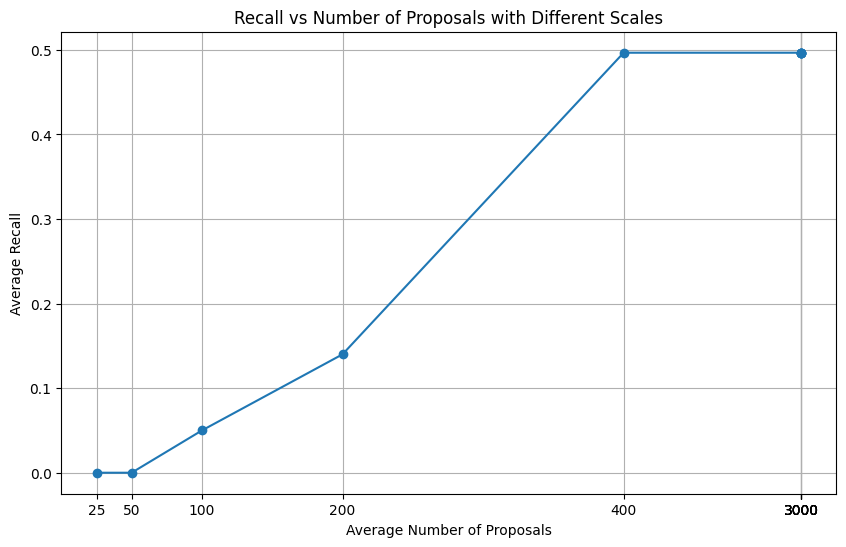

In [30]:
# To change the number of proposals we will vary the scale on the selectivesearch function 
# (this is done to not truncate and have a better distribution of the proposals)
scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]
# MAX_IMAGES = 20 # Number of image we will take into account to do the recall
image_count = 0

# Keep the recalls in a diccionary
results = {scale: {'num_proposals': 0, 'recall': []} for scale in scales}


# Loop through images to evaluate proposals
for image_filename in os.listdir(images_path):
    print(image_filename)
    if image_filename.endswith(".jpg"):
        # Stop processing after reaching the limit of images
        # if image_count >= MAX_IMAGES:
        #     break

        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)
        
        # Load image and ground truth
        image = cv2.imread(image_path)
        if os.path.exists(xml_path):
            ground_truth_boxes = parse_xml(xml_path)
            
            # Dimensions for resizing image 
            orig_height, orig_width = image.shape[:2]
            scale_x = TARGET_WIDTH / orig_width
            scale_y = TARGET_HEIGHT / orig_height
            
            # Resize ground truth boxes
            resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
             # Resize image and generate proposals
            resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            

            # Evaluate for each proposal_count
            for scale in scales:
                proposals = get_proposals(resized_image, scale)
                results[scale]['num_proposals'] += len(proposals)

                # Calculate the recall 
                recall = calc_recall(proposals, resized_gt_boxes, iou_threshold=0.5)
                results[scale]['recall'].append(recall)

            image_count += 1
            print (f"{image_filename}:{image_count}, {len(proposals)}", end="\r")


# Calculate average recall and the number of proposals for each scale
average_recalls = {scale: np.mean(results[scale]['recall']) for scale in scales}

# Prepare data for plotting
average_num_proposals = {scale: results[scale]['num_proposals'] / image_count for scale in scales} 

# Sort the scales based on the average number of proposals
sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
sorted_recalls = [average_recalls[scale] for scale in sorted_scales]

# Display the results and the number of proposals per scale
# for scale in scales:
#     print(f"Scale: {scale}, Average Proposals: {num_proposals:.2f}, Average Recall: {average_recalls[scale]:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))

num_proposals = [results[scale]['num_proposals'] / len(os.listdir(images_path)) for scale in scales]
recalls = [average_recalls[scale] for scale in scales]
plt.plot(num_proposals, recalls, marker='o')

plt.xlabel("Average Number of Proposals")
plt.ylabel("Average Recall")
plt.title("Recall vs Number of Proposals with Different Scales")
plt.xticks(ticks=num_proposals, labels=scales)
plt.grid()
plt.show()

We now create a function to evaluate the best number of proposals, we are using 5 selected photos and calculate its recall using different numbers of proposals. Then we do the average of the recall of all the photos per num_proposals.

image:img-18.jpg 30:
image:img-20.jpg 30:     :30/2900
image:img-28.jpg 30:     :30/2900
image:img-32.jpg 30:     :30/2900
image:img-5.jpg 30:      :30/2900


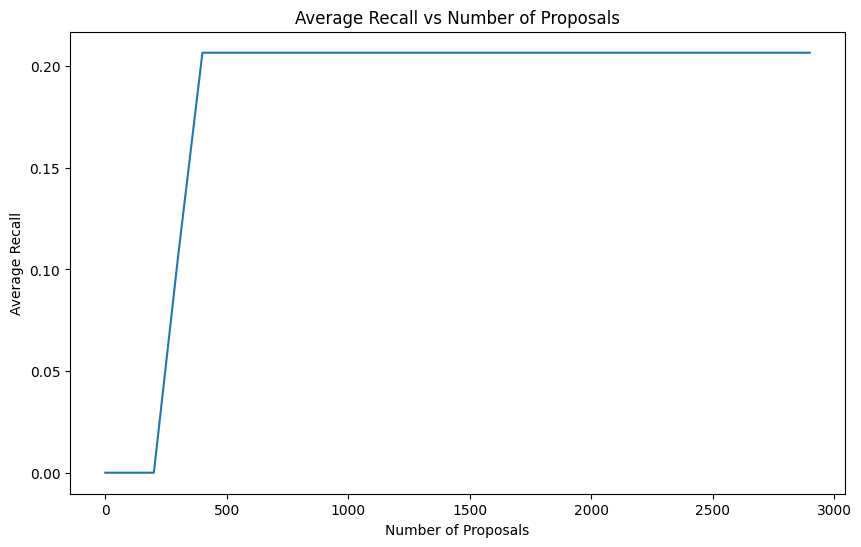

In [23]:
# Function to evaluate the optimal number of proposals needed for the dataset
def evaluate_proposal_count(images_path, annotations_path, target_proposals, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT, iou_threshold=0.6):
    recall_results = {num: [] for num in target_proposals}  # Dictionary to store recall for each number of proposals

    for image_filename in os.listdir(images_path):
        if image_filename.lower().endswith(".jpg"):
            image_path = os.path.join(images_path, image_filename)
            xml_filename = image_filename.lower().replace(".jpg", ".xml")
            xml_path = os.path.join(annotations_path, xml_filename)

            # Load the image
            image = cv2.imread(image_path)
            orig_height, orig_width = image.shape[:2]
            scale_x = target_width / orig_width
            scale_y = target_height / orig_height

            # Resize the image for more efficient Selective Search processing
            resized_image = cv2.resize(image, (target_width, target_height))
            resized_image_int = (resized_image * 255).astype(np.uint8)

            if os.path.exists(xml_path):
                ground_truth_boxes = parse_xml(xml_path)
                
                # Adjust the ground truth boxes to the resized dimensions
                adjusted_boxes = [
                    (int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y))
                    for xmin, ymin, xmax, ymax in ground_truth_boxes
                ]

                # Test different numbers of proposals
                print (f"image:{image_filename} {len(target_proposals)}:")
                n = 0 
                for num_proposals in target_proposals:
                    n += 1
                    # Generate proposals with the specified number of proposals
                    proposals = get_proposals(resized_image_int, num_proposals=num_proposals)

                    # Calculate recall for the generated proposals
                    recall = calc_recall(proposals, adjusted_boxes, iou_threshold)
                    
                    # Append the recall value to the results dictionary for this number of proposals
                    recall_results[num_proposals].append(recall)
                    print (f"{image_filename} - num_proposal:{n}/{num_proposals}", end="\r")

        print ("Image_filename", " "*10, end="\r")
    # Compute the average recall for each number of proposals
    avg_recall_results = {num: np.mean(recalls) for num, recalls in recall_results.items()}
    
    return avg_recall_results

# Run the evaluation and view results
recall_per_proposal_count = evaluate_proposal_count(
    images_path, 
    annotations_path, 
    target_proposals=range(0, 3000, 100) #number of proposals
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(list(recall_per_proposal_count.keys()), list(recall_per_proposal_count.values()), linestyle='-')
plt.xlabel("Number of Proposals")
plt.ylabel("Average Recall")
plt.title("Average Recall vs Number of Proposals")
plt.grid(False)
plt.show()

### Loop for evaluating the ABO and choosing the number of proposals

In [ ]:
# Constants
scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]  # Different scales to test
image_count = 0  # Counter for images processed

# Dictionary to store the ABO and the number of proposals for each scale
results_abo = {scale: {'num_proposals': 0, 'abo': []} for scale in scales}

# Loop through images to evaluate proposals
for image_filename in os.listdir(images_path):
    print(image_filename)
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)

        # Load image and ground truth
        image = cv2.imread(image_path)
        if os.path.exists(xml_path):
            ground_truth_boxes = parse_xml(xml_path)

            # Resize dimensions
            orig_height, orig_width = image.shape[:2]
            scale_x = TARGET_WIDTH / orig_width
            scale_y = TARGET_HEIGHT / orig_height

            # Resize ground truth boxes
            resized_gt_boxes = [
                (int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y))
                for xmin, ymin, xmax, ymax in ground_truth_boxes
            ]

            # Resize image and generate proposals
            resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

            # Evaluate for each scale
            for scale in scales:
                # Generate proposals using the current scale
                proposals = get_proposals(resized_image, scale)
                results_abo[scale]['num_proposals'] += len(proposals)

                # Calculate the ABO for this set of proposals
                abo_value = calculate_abo(proposals, resized_gt_boxes)
                results_abo[scale]['abo'].append(abo_value)

            image_count += 1
            print(f"{image_filename}: Processed {image_count} images", end="\r")

# Calculate average ABO and average number of proposals for each scale
average_abos = {scale: np.mean(results_abo[scale]['abo']) for scale in scales}
average_num_proposals = {scale: results_abo[scale]['num_proposals'] / image_count for scale in scales}

# Sort the scales based on the average number of proposals
sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
sorted_abos = [average_abos[scale] for scale in sorted_scales]

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(sorted_num_proposals, sorted_abos, marker='o')

plt.xlabel("Average Number of Proposals")
plt.ylabel("Average ABO")
plt.title("ABO vs Number of Proposals with Different Scales")
plt.xticks(ticks=sorted_num_proposals, labels=sorted_scales)
plt.ylim(0, 1)  # Ensure ABO values are between 0 and 1
plt.grid()
plt.show()
